In [1]:
#importing the necessary libraries
import numpy as np
import pandas as pd 
import pydicom as dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Working directory 
INPUT_FOLDER = 'D:/FBK/Clinical Data/3-13-2023/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()

In [2]:
patients

['R01-136', 'R01-133', 'R01-136', 'R01-141', 'R01-142', 'R01-145']

In [3]:
# Load the scans in given folder path
def load_scan(path):
    # for s in os.listdir(path):
    #     print(path + '/' + s)
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [4]:
def get_pixels_hu_slices(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [237]:
dcm1 = dicom.dcmread(dcms[0])
dcm2 = dicom.dcmread(dcms[2])

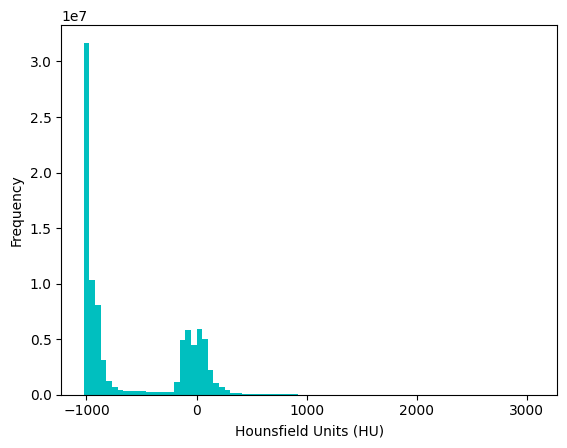

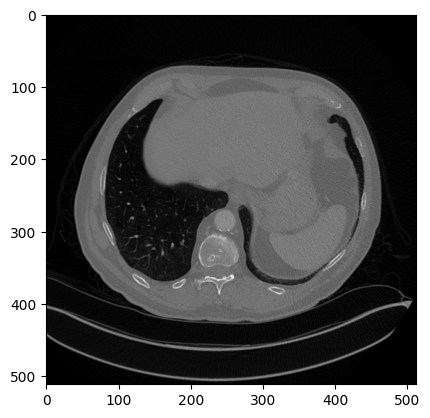

In [26]:
folder = os.listdir(INPUT_FOLDER + patients[1] + '/CT')
first_patient_ct = load_scan(INPUT_FOLDER + patients[1] + '/CT/' + folder[0])
first_patient_ct_pixels = get_pixels_hu_slices(first_patient_ct)
plt.hist(first_patient_ct_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_ct_pixels[80], cmap=plt.cm.gray)
plt.show()

In [31]:
# Determine current pixel spacing
new_spacing = [1,1,1]
c = [1]
scan = first_patient_ct
image = first_patient_ct_pixels
spacing = np.array([scan[0].SliceThickness] + list(scan[0].PixelSpacing) + c, dtype=np.float32)
print(spacing)
resize_factor = spacing / new_spacing
print(resize_factor[2])
resize_factor = new_spacing
print(image.shape)
new_real_shape = image.shape * resize_factor

new_shape = np.round(new_real_shape)
real_resize_factor = new_shape / image.shape
new_spacing = spacing / real_resize_factor

image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')

C:\Users\Huma Rehman\AppData\Local\Temp\ipykernel_16860\2535895749.py:9: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')


In [5]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + list(scan[0].PixelSpacing), dtype=np.float32)

    resize_factor = spacing / new_spacing
    resize_factor = new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [6]:
def resample_3channels(image, scan, new_spacing=[1,1,1,1]):
    # Determine current pixel spacing
    # new_spacing = [0.5,0.5,0.5,1]
    c = [1]
    # scan = first_patient_ct
    # image = first_patient_ct_pixels 
    spacing = np.array([scan[0].SliceThickness] + list(scan[0].PixelSpacing) + c, dtype=np.float64)
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [30]:
pix_resampled, spacing = resample(first_patient_ct_pixels, first_patient_ct, [1,1,1])
print("Shape before resampling\t", first_patient_ct_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

TypeError: can't multiply sequence by non-int of type 'list'

NameError: name 'p' is not defined

In [47]:
def plot_3d(image, threshold=-200):
    threshold = -200
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(3,2,1,0)
    
    verts, faces,norm, val = measure._marching_cubes_lewiner(p)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    
    plt.show()

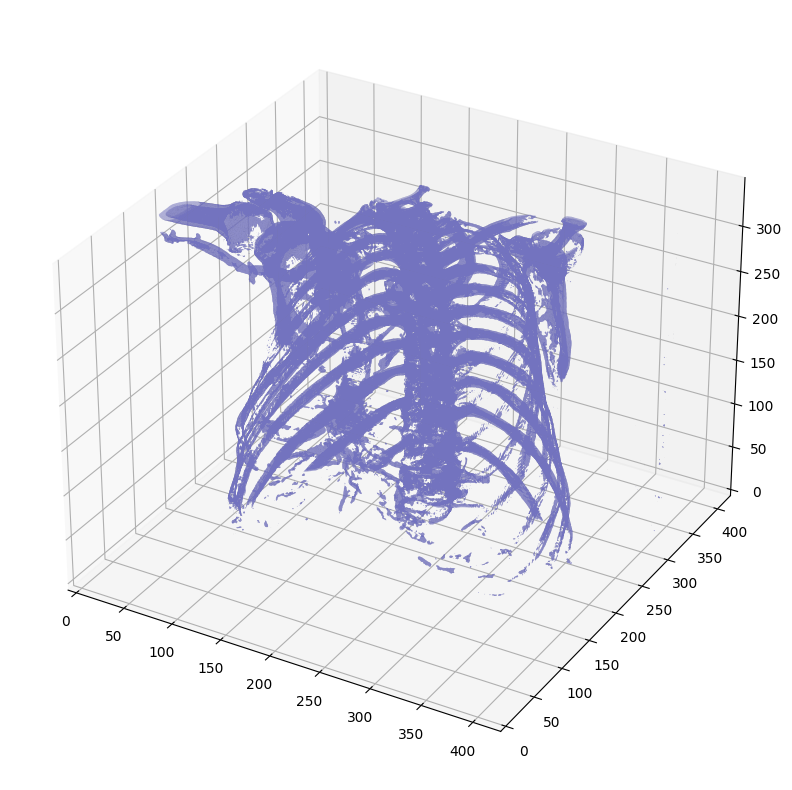

In [11]:
plot_3d(pix_resampled, 400)

In [7]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    # Pick the pixel in the very corner to determine which label is air.
    background_label = labels[0,0,0]
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    # Method of filling the lung structures 
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

In [13]:
segmented_lungs = segment_lung_mask(pix_resampled, False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, True)

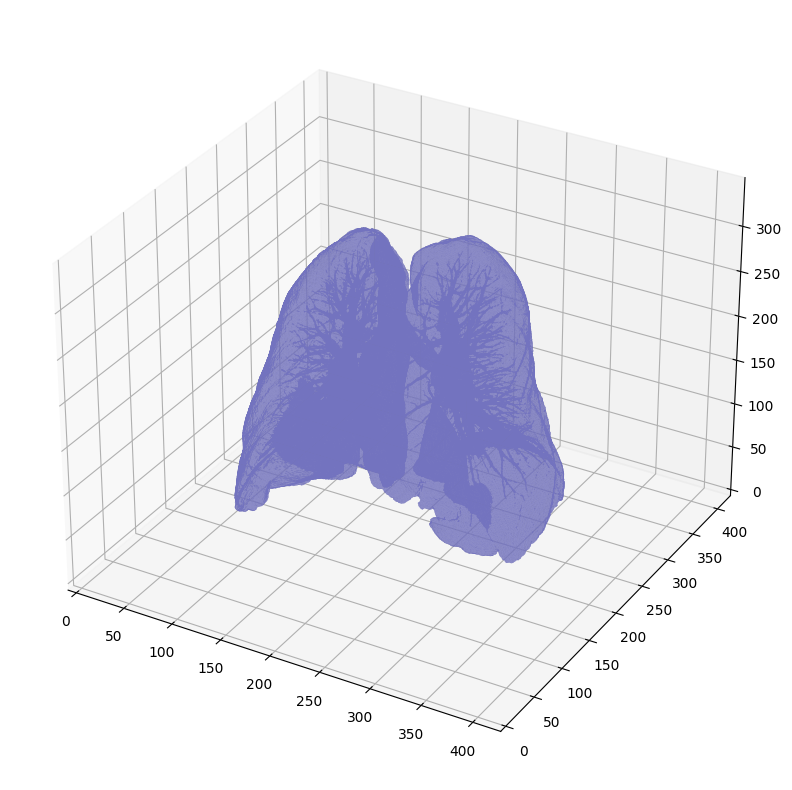

In [14]:
plot_3d(segmented_lungs, 0)

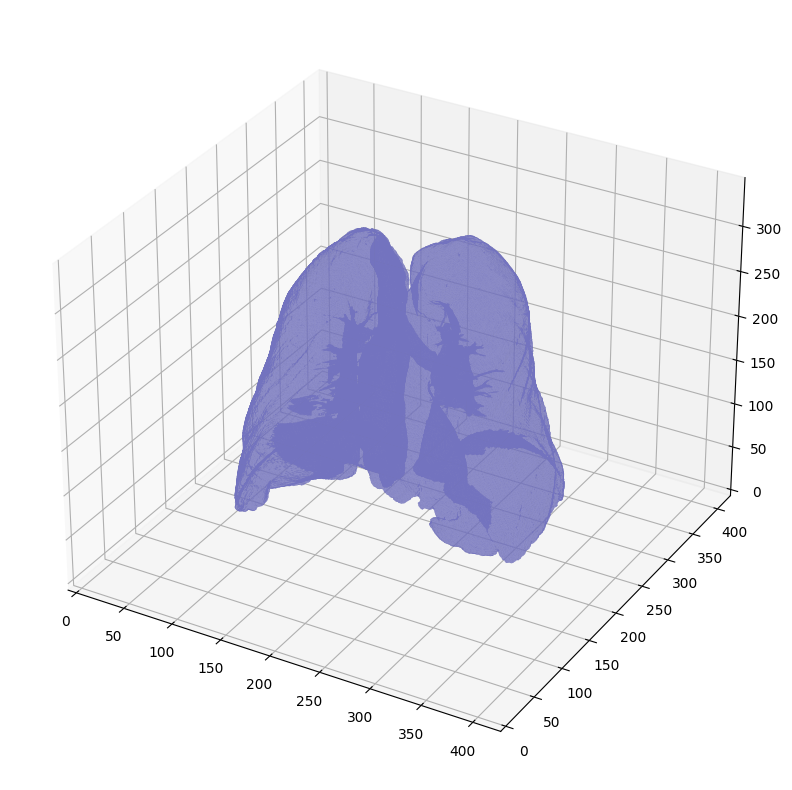

In [15]:
plot_3d(segmented_lungs_fill, 0)

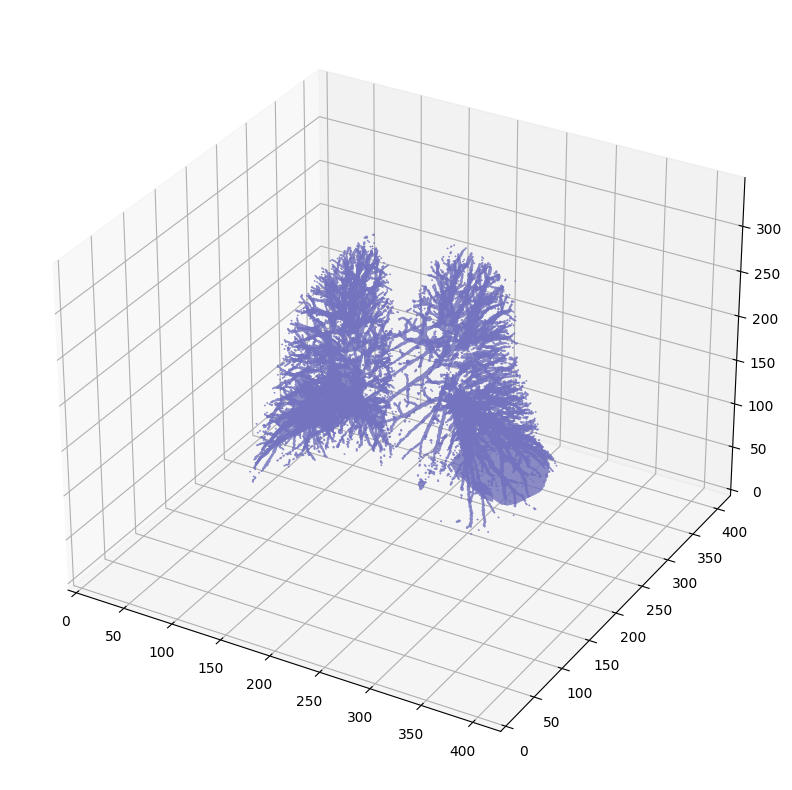

In [16]:
plot_3d(segmented_lungs_fill - segmented_lungs, 0)

In [17]:
# from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# import numpy as np
# from skimage import measure

# def plot_3d_seg(image, threshold=-300): 
#     p = image.transpose(2,1,0)
#     verts, faces, normals, values = measure.marching_cubes_lewiner(p, threshold)
#     fig = plt.figure(figsize=(10, 10))
#     ax = fig.add_subplot(111, projection='3d')
#     mesh = Poly3DCollection(verts[faces], alpha=0.1)
#     face_color = [0.5, 0.5, 1]
#     mesh.set_facecolor(face_color)
#     ax.add_collection3d(mesh)
#     ax.set_xlim(0, p.shape[0])
#     ax.set_ylim(0, p.shape[1])
#     ax.set_zlim(0, p.shape[2])

#     plt.show()

# file = "D:/FBK/Clinical Data/3-13-2023/R01-133/SEG/1-298.dcm"
# image = dicom.read_file(file)
# plot_3d_seg(image, threshold=-300)

In [8]:
def get_pixels_hu(image, intercept, slope):
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)  
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)

    # Remove bones
    image[image >700] = 0
    
    return np.array(image, dtype=np.int16)

In [41]:
import pydicom
import matplotlib.pyplot as plt
from pydicom import dcmread
from pydicom.data import get_testdata_file
import cv2
import glob
import numpy as np
from pydicom.dataset import Dataset
import imageio
import SimpleITK as sitk
# The path to a pydicom test dataset which is segmented
path = "D:/FBK/Clinical Data/3-13-2023/R01-133/SEG/1.3.6.1.4.1.14519.5.2.1.4334.1501.494784143900303026856622998040/1-298.dcm"
ds = dcmread(path)

In [57]:
dcms = []
for root, dirs, fnames in sorted(os.walk('D:/FBK/Clinical Data/3-13-2023/R01-133/CT')):
    dcms += list(os.path.join(root, f) for f in sorted(fnames) if f.endswith('.dcm'))
print(f'There are {len(dcms)} CT scans')

There are 346 CT scans


In [58]:
fnames = fnames.sort(key=lambda f: str(filter(str.isdigit, f)))

In [59]:
fnames

In [60]:
reference_CT = ds[0x0008, 0x1115][0][0x0008, 0x114a]
segmentation_dict = {}

In [62]:
reference_CT

<Sequence, length 39>

In [61]:
for i,seg in enumerate(reference_CT):
    seg_array = seg[0x0008, 0x1155].value
    seg_array = ds.pixel_array
    seg_filter = seg_array[i]
    segmentation_dict[seg[0x0008, 0x1155].value] = seg_filter

In [24]:
print(ds[0x0070, 0x0080][0])

R


In [25]:
# ds

In [13]:
# new_path = 'D:/FBK/Clinical Data/3-13-2023/R01-133/CT/1.3.6.1.4.1.14519.5.2.1.4334.1501.913365821057799133982597420952/overlay_images/'
# os.makedirs(new_path)



In [111]:
def new_file(data):
    import pydicom
    from pydicom.dataset import Dataset, FileDataset
    from pydicom.uid import ExplicitVRLittleEndian
    import pydicom._storage_sopclass_uids

    image2d = data

    # print("Setting file meta information...")
    # Populate required values for file meta information

    meta = pydicom.Dataset()
    meta.MediaStorageSOPClassUID = pydicom._storage_sopclass_uids.MRImageStorage
    meta.MediaStorageSOPInstanceUID = pydicom.uid.generate_uid()
    meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian  

    ds = Dataset()
    ds.file_meta = meta

    ds.is_little_endian = True
    ds.is_implicit_VR = False

    ds.SOPClassUID = pydicom._storage_sopclass_uids.MRImageStorage
    ds.PatientName = "ggest"
    ds.PatientID = "123456"

    ds.Modality = "CT"
    ds.SeriesInstanceUID = pydicom.uid.generate_uid()
    ds.StudyInstanceUID = pydicom.uid.generate_uid()
    ds.FrameOfReferenceUID = pydicom.uid.generate_uid()

    ds.BitsStored = 16
    ds.BitsAllocated = 16
    ds.SamplesPerPixel = 3
    ds.HighBit = 15

    ds.ImagesInAcquisition = "1"

    ds.Rows = 512
    ds.Columns = 512
    ds.PixelSpacing = [1.0, 1.0]
    ds.PixelRepresentation = 0
    ds.PhotometricInterpretation = 'RGB'
    ds.InstanceNumber = 1

    ds.ImagePositionPatient = r"0\0\1"
    ds.ImageOrientationPatient = r"1\0\0\0\1\0"
    ds.ImageType = r"ORIGINAL\PRIMARY\AXIAL\CT_SOM5 SPI"

    # ds.RescaleIntercept = "0"
    # ds.RescaleSlope = "1"
    ds.PixelSpacing = [0.5, 0.5]
    ds.PhotometricInterpretation = "RGB"

    pydicom.dataset.validate_file_meta(ds.file_meta, enforce_standard=True)
    # print("Setting pixel data...")
    ds.PixelData = image2d.tobytes()
    return ds

In [14]:
import cv2

In [252]:

for dcm in dcms:
    file = pydicom.read_file(dcm)
    # print(type(file[0x0008, 0x0018])
    # break
    if str(file[0x0008, 0x0018].value) in segmentation_dict.keys():
        
        seg_pix = segmentation_dict[file[0x0008, 0x0018].value]
        CT = file.pixel_array
        CT_hu = get_pixels_hu(CT, file.RescaleIntercept, file.RescaleSlope)

        # here we will convert the segmentation pixels to rgb and save them
        binary_array = seg_pix
        # # multiply binary array by 255 to convert to grayscale image
        gray_image = binary_array * 255.0
        # # create empty RGB image with same dimensions as binary image
        rgb_image = np.zeros((binary_array.shape[0], binary_array.shape[1], 3),dtype="int16")
        # # set red color for all 1's in binary array
        rgb_image[binary_array == 1] = (255,0, 0)

        #  now here we will work on CT image and overlay the segmentation on it 
        # Convert 2D array to 3D array by adding a new axis
        test_ct = CT_hu
        test_ct = np.repeat(test_ct[:, :, np.newaxis], 3, axis=2)
        overlay_img = cv2.addWeighted(rgb_image, 30,test_ct, 1, 0)
        # new_dcm = Dataset.from_file(overlay_img)
        # Extract the pixel data from the new DICOM file
        # new_pixel_data = new_dcm.pixel_array
        # Replace the pixel data in the original DICOM file#
        # nfile=new_file(overlay_img)
        file.PhotometricInterpretation = 'RGB'
        # file.NumberOfFrames = 3
        file.SamplesPerPixel = 3
        file.BitsAllocated = 16
        file.BitsStored = 16
        file.HighBit = 15
        file.add_new(0x00280006, 'US', 0)
        file.is_little_endian = True
        file.fix_meta_info()
        file.PixelData = overlay_img.tobytes()
        name = dcm.split("\\")[-1].split('.')[0]
        dc_filepath = new_path + dcm.split("\\")[-1]
        # cv2.imwrite(new_path + str(name) + '.png',overlay_img)
        # dicom.dcmwrite(dc_filepath,dc_filepath)
        file.save_as(dc_filepath)
        CT_list[file[0x0008, 0x0018].value] = CT_hu
    else:
        array = file.pixel_array
        test_ct = np.repeat(array[:, :, np.newaxis], 3, axis=2)
        file.PhotometricInterpretation = 'RGB'
        # file.NumberOfFrames = 3
        file.SamplesPerPixel = 3
        file.BitsAllocated = 16
        file.BitsStored = 16
        file.HighBit = 15
        file.add_new(0x00280006, 'US', 0)
        file.is_little_endian = True
        file.fix_meta_info()
        file.PixelData = test_ct.tobytes()
        name = dcm.split("\\")[-1].split('.')[0]
        dc_filepath = new_path + dcm.split("\\")[-1]
        # cv2.imwrite(new_path + str(name) + '.png',overlay_img)
        # dicom.dcmwrite(dc_filepath,dc_filepath)
        file.save_as(dc_filepath)

In [1]:
folder = os.listdir(INPUT_FOLDER + patients[1])
first_patient_ct = load_scan(INPUT_FOLDER + patients[1] + '/overlay_images')
first_patient_ct_pixels = get_pixels_hu_slices(first_patient_ct)
plt.hist(first_patient_ct_pixels.flatten(), bins=100, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()
# Show some slice in the middle
plt.imshow(first_patient_ct_pixels[30])
plt.show()

NameError: name 'os' is not defined

In [11]:
# Determine current pixel spacing# Determine current pixel spacing
new_spacing = [1,1,1,1]
c = [1]
scan = first_patient_ct
image = first_patient_ct_pixels 
spacing = np.array([scan[0].SliceThickness] + list(scan[0].PixelSpacing) + c, dtype=np.float32)
resize_factor = spacing
new_real_shape = image.shape * resize_factor
new_shape = np.round(new_real_shape)
real_resize_factor = new_shape / image.shape
new_spacing = spacing / real_resize_factor
image = scipy.ndimage.interpolation.zoom(image[:200,:200,:200,:], real_resize_factor, mode='nearest')

C:\Users\Huma Rehman\AppData\Local\Temp\ipykernel_3488\2156538163.py:12: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  image = scipy.ndimage.interpolation.zoom(image[:200,:200,:200,:], real_resize_factor, mode='nearest')


In [34]:
# pix_resampled, spacing = resample_3channels(first_patient_ct_pixels, first_patient_ct, [1,1,1,1])
# print("Shape before resampling\t", first_patient_ct_pixels.shape)
# print("Shape after resampling\t", pix_resampled.shape)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [37]:
# plot_3d(image, 200)

In [41]:
threshold = -200
# Position the scan upright, 
# so the head of the patient would be at the top facing the camera
# p = image.transpose(3,2,1,0)
# print(p[0].shape)
verts, faces,norm, val = measure.marching_cubes(image, threshold)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces], alpha=0.70)
face_color = [0.45, 0.45, 0.75]
mesh.set_facecolor(face_color)
ax.add_collection3d(mesh)

ax.set_xlim(0, p.shape[0])
ax.set_ylim(0, p.shape[1])
ax.set_zlim(0, p.shape[2])

    
plt.show()

ValueError: Input volume should be a 3D numpy array.

In [14]:
CT_list = {}

In [15]:
ctkeys = list(CT_list.keys())
segkeys = list(segmentation_dict.keys())

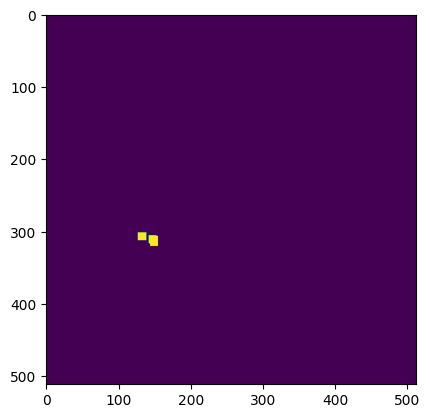

In [16]:
plt.imshow(segmentation_dict[segkeys[4]])

In [48]:
test_seg = segmentation_dict[segkeys[4]]
import cv2
import numpy as np

# # create binary array of image (assuming 0 for black and 1 for white)
binary_array = test_seg

# # multiply binary array by 255 to convert to grayscale image
gray_image = binary_array * 255.0

# # create empty RGB image with same dimensions as binary image
rgb_image = np.zeros((binary_array.shape[0], binary_array.shape[1], 3),dtype="int16")

# # set red color for all 1's in binary array
rgb_image[binary_array == 1] = (255,0, 0)  # red color in BGR format

# show RGB image

# heatmap_img = cv2.applyColorMap(test_seg, cv2.COLORMAP_BONE)

# cv2.imshow("heatmap_img",test_seg)
# cv2.imwrite("heatmap_img.png",heatmap_img)
# cv2.waitKey(0)

# # closing all open windows
# cv2.destroyAllWindows()

# data = binary_array

# # a colormap and a normalization instance
# cmap = plt.cm.jet
# norm = plt.Normalize(vmin=data.min(), vmax=data.max())

# # map the normalized data to colors
# # image is now RGBA (512x512x4) 
# image = cmap(norm(data))

# save the image
# plt.imsave('test.png', rgb_image)
cv2.imwrite('test.png', rgb_image)

True

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


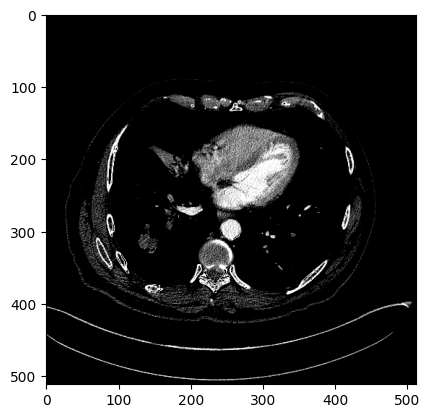

In [139]:
test_ct = CT_list[ctkeys[4]]


# Convert 2D array to 3D array by adding a new axis
test_ct = np.repeat(test_ct[:, :, np.newaxis], 3, axis=2)
plt.imshow(test_ct)
plt.show()

In [53]:
type(rgb_image)
type(test_ct[0])

numpy.ndarray

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


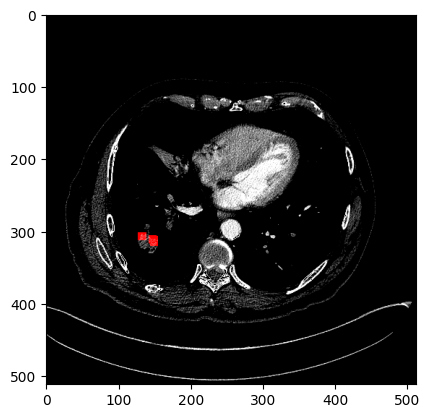

In [54]:
# test_ct = test_ct.astype("float32")
# rgb_image = rgb_image.astype("float32")
overlay_img = cv2.addWeighted(rgb_image, 30,test_ct, 1, 0)
cv2.imwrite("fullim.png",overlay_img)
plt.imshow(overlay_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


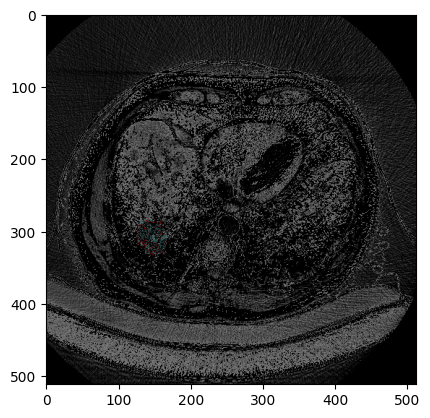

In [60]:
overlay_img = overlay_img.astype("int8")
plt.imshow(overlay_img)

NameError: name 'dcm1' is not defined

In [56]:
reference_CT

<Sequence, length 39>